# Introduction to PyTorch

# Implementing an MLP in PyTorch for predicting body fat percentage.

We have the PMLB database [1] consisting of 252 measurements of body fat percentage from 252 different individuals, which can be estimated using other characteristics such as age, weight, and measurements from various parts of the body. From these data, we aim to develop a system that allows predicting this percentage based on these characteristics.

[1] Olson, R.S., La Cava, W., Orzechowski, P. et al. PMLB: a large benchmark suite for machine learning evaluation and comparison. BioData Mining 10, 36 (2017). https://epistasislab.github.io/pmlb/profile/560_bodyfat.html

Before we begin, let's install the Python package containing the database:

In [1]:
pip install pmlb

Now we're going to generate a histogram of all the percentage measurements with all the available data:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pmlb import fetch_data


# Importing the data set
body_fat = fetch_data('560_bodyfat')
body_fat.describe()

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,target
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,44.884921,178.924405,70.148810,37.992064,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762,19.150794
std,0.019031,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411804,1.694894,3.021274,2.020691,0.933585,8.368740
min,0.995000,22.000000,118.500000,29.500000,31.100000,79.300003,69.400002,85.000000,47.200001,33.000000,19.100000,24.799999,21.000000,15.800000,0.000000
25%,1.041400,35.750000,159.000000,68.250000,36.400002,94.350000,84.574999,95.500000,56.000000,36.975000,22.000000,30.200001,27.299999,17.600000,12.475000
50%,1.054900,43.000000,176.500000,70.000000,38.000000,99.649998,90.950001,99.300003,59.000000,38.500000,22.799999,32.049999,28.700001,18.299999,19.200001
75%,1.070400,54.000000,197.000000,72.250000,39.425001,105.375002,99.324997,103.525000,62.349999,39.925001,24.000000,34.325000,30.000000,18.799999,25.299999
max,1.108900,81.000000,363.149994,77.750000,51.200001,136.199997,148.100006,147.699997,87.300003,49.099998,33.900002,45.000000,34.900002,21.400000,47.500000


In [3]:
# Extracting the features and the percentages (labels to predict)
data = body_fat.loc[:, body_fat.columns != 'target'].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == 'target'].to_numpy()

data = data.astype(np.float32)
percentages = percentages.astype(np.float32)

print("example row:")
print(list(body_fat.columns))
print(data[4,:])

example row:
['Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'target']
[  1.034  24.    184.25   71.25   34.4    97.3   100.    101.9    63.2
  42.2    24.     32.2    27.7    17.7  ]


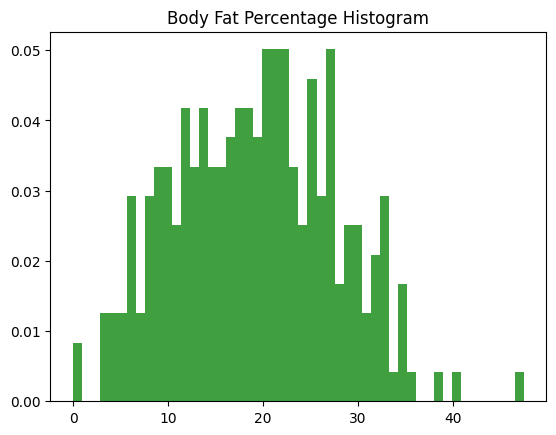

In [4]:
# Drawing a histogram of the body fat percentage using all the data
_ = plt.hist( percentages, 50, density=True, facecolor='g', alpha=0.75)
_ = plt.title("Body Fat Percentage Histogram")

In [5]:
from sklearn.model_selection import train_test_split
# We partition the data into training and testing sets using the  `sklearn.model_selection.train_test_split`
X_train, X_test, y_train, y_test = train_test_split(data , percentages , test_size=0.33, random_state=42)

In [6]:
X_train.shape, y_train.shape

((168, 14), (168, 1))

In [7]:
X_test.shape, y_test.shape

((84, 14), (84, 1))

Now we will implement a Multilayer Perceptron in PyTorch that we will use as a regressor for body fat percentage.

The perceptron will have 3 layers (2 hidden layers and 1 output layer):

- The first two with 200 neurons, and they will use the ReLU activation function.
- The last one with a single neuron whose output is a scalar value corresponding to the estimated body fat percentage of the individual, and it will not use any activation function.

Some PyTorch classes that will be useful for implementing the model are:
- torch.nn.Linear: Implements a fully connected layer. It is necessary to specify the number of input and output parameters.
- torch.nn.functional.relu: Implements the ReLU activation function.

Additionally, we will use the torch.optim.Adam optimizer and the torch.nn.MSELoss (Mean Squared Error) loss function.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Training batch size
batch_size = 32

# Initial learning rate for gradient descent
learning_rate = 1e-3

# We define the Net class which will represent the perceptron
class Net(torch.nn.Module):
    # In the init function (known as the class constructor), we define the layers that will be used
    # in the neural network.
    def __init__(self, input_features, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)
    # In the forward function, we define how the layers will be connected, i.e., how the data will flow
    # within the network
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [9]:
# We instantiate an object of the Net class
# This object will be a perceptron to which we must specify the size of the different layers
net = Net( input_features= data.shape[1] , size_hidden = 200 , n_output = 1 )

In [10]:
net

Net(
  (hidden1): Linear(in_features=14, out_features=200, bias=True)
  (hidden2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=1, bias=True)
)

In [11]:
# We construct the optimizer, and specify that the parameters to optimize
# are those of the defined model: net.parameters()
optimizer = torch.optim.Adam( net.parameters() , lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [12]:
# We also define the loss function to use
criterion = nn.MSELoss()
criterion

MSELoss()

In [13]:
# We create the dataset object that packages the numpy arrays so they can
# be read by PyTorch
dataset = TensorDataset(torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone())
dataset

In [14]:
# We create an iterable loader indicating that it should read the data from
# the dataset created in the previous step. This object can be iterated
# and returns one batch (x, y) at a time.
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
loader

In [15]:
# Number of epochs
num_epochs = 5000

# List where we will keep track of the loss function value at each
# training stage
loss_list = []

# Training loop
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        # Set gradients of the parameters to optimize to zero
        optimizer.zero_grad()

        # Perform the forward pass through the network
        outputs = net(x)
        loss = criterion(outputs, y)

        # Perform the backward pass through the network
        loss.backward()

        # Update the weights of the network with the optimizer
        optimizer.step()

        # I save the current value of the loss function to later plot it
        loss_list.append(loss.data.item())

        # I accumulate the loss of the minibatch
        total_loss += loss.item() * y.size(0)

    # I normalize the total loss
    total_loss/= len(loader.dataset)

    # I display the value of the loss function every 100 iterations
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

Epoch 100, loss = 19.4313
Epoch 200, loss = 16.9717
Epoch 300, loss = 16.9211
Epoch 400, loss = 14.5228
Epoch 500, loss = 15.054
Epoch 600, loss = 13.6817
Epoch 700, loss = 10.1312
Epoch 800, loss = 9.32302
Epoch 900, loss = 8.18691
Epoch 1000, loss = 7.09645
Epoch 1100, loss = 4.95795
Epoch 1200, loss = 3.61263
Epoch 1300, loss = 2.97425
Epoch 1400, loss = 2.16168
Epoch 1500, loss = 2.33458
Epoch 1600, loss = 3.07036
Epoch 1700, loss = 0.930905
Epoch 1800, loss = 1.04372
Epoch 1900, loss = 1.03749
Epoch 2000, loss = 2.58797
Epoch 2100, loss = 0.914383
Epoch 2200, loss = 0.509682
Epoch 2300, loss = 0.498768
Epoch 2400, loss = 0.947208
Epoch 2500, loss = 3.15117
Epoch 2600, loss = 1.56071
Epoch 2700, loss = 0.66688
Epoch 2800, loss = 0.334257
Epoch 2900, loss = 2.40783
Epoch 3000, loss = 0.166033
Epoch 3100, loss = 0.834447
Epoch 3200, loss = 0.429926
Epoch 3300, loss = 0.872244
Epoch 3400, loss = 1.00692
Epoch 3500, loss = 0.660382
Epoch 3600, loss = 0.16181
Epoch 3700, loss = 0.817669

Text(0.5, 1.0, 'Loss function during training')

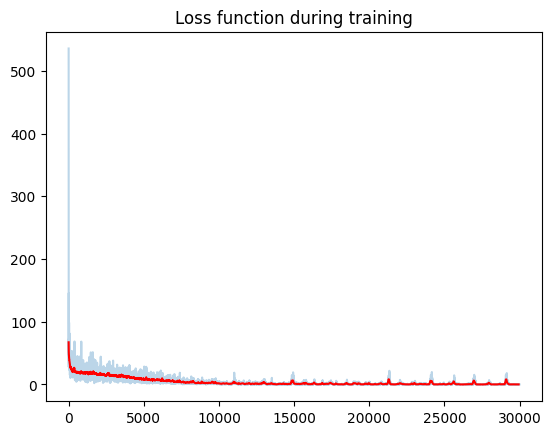

In [16]:
# Show the list containing the values of the loss function and a smoothed version (red) to observe the trend.
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Loss function during training")

Mean MSE in training with 200 neurons: 0.32137474
Mean MSE in test with 200 neurons: 34.73385


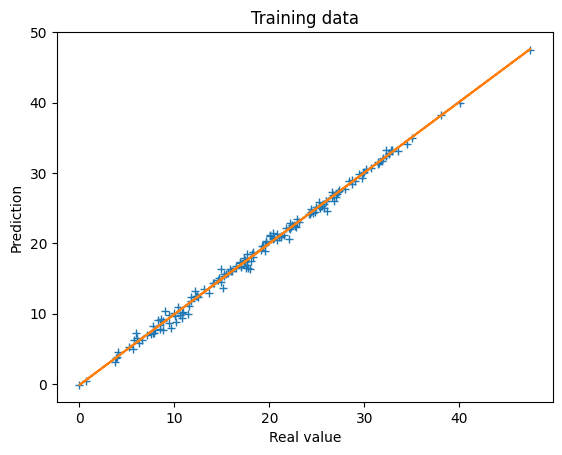

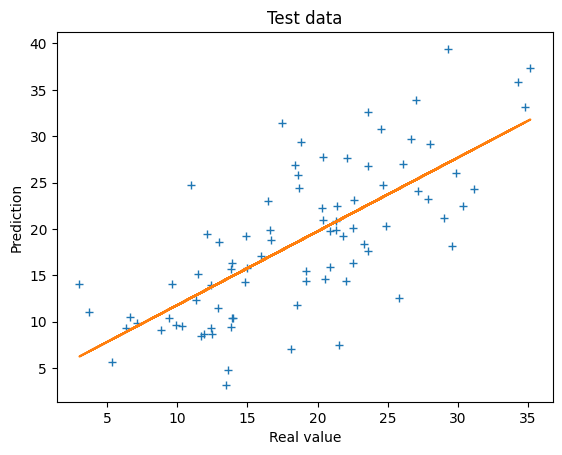

In [17]:
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm

# We define a method to display the predictions as a scatter plot and plot the
# regression line for those data.

def plotScatter(x_data, y_data, title, fit_line=True):
  plt.figure()

  plt.plot(x_data, y_data, '+')
  plt.xlabel('Real value')
  plt.ylabel('Prediction')
  plt.title(title)

  if fit_line:
    X, Y = x_data.reshape(-1,1), y_data.reshape(-1,1)
    plt.plot( X, LinearRegression().fit(X, Y).predict(X) )

# We draw the ground truth vs the predictions on the training data.
py = net(torch.FloatTensor(X_train))
y_pred_train = py.cpu().detach().numpy()
plotScatter(y_train, y_pred_train, "Training data")

# We draw the ground truth vs the predictions on the test data.
py = net(torch.FloatTensor(X_test))
y_pred_test = py.cpu().detach().numpy()
plotScatter(y_test, y_pred_test, "Test data")

MSE200_train = ((y_train - y_pred_train)**2).mean()
MSE200_test = ((y_test - y_pred_test)**2).mean()

print ("Mean MSE in training with 200 neurons: " + str(MSE200_train))
print ("Mean MSE in test with 200 neurons: " + str(MSE200_test))

# Comparing Multilayer Perceptrons with Varied Hidden Layer Neurons"


Now we will compare the performance of 3 multilayer perceptrons that vary in the number of neurons in their hidden layers. We will try 2 and 10 neurons in these layers and then training the perceptrons for 5000 epochs in order to analyze the relationship between these results and the number of neurons in the perceptron.


We will show the results using:

* scatter plots with regression lines

* the mean error in the training and test data




In [18]:
criterion = torch.nn.MSELoss(reduction='mean')
print(type(criterion))

<class 'torch.nn.modules.loss.MSELoss'>


## Multilayer Perceptron with 2 neurons per layer trained for 5000 epochs

In [19]:
# We instantiate the object of the previously defined Net class (perceptron)
net = Net( input_features= data.shape[1] , size_hidden = 2 , n_output = 1 )
net

Net(
  (hidden1): Linear(in_features=14, out_features=2, bias=True)
  (hidden2): Linear(in_features=2, out_features=2, bias=True)
  (out): Linear(in_features=2, out_features=1, bias=True)
)

In [20]:
# We construct the optimizer
optimizer = torch.optim.Adam( net.parameters() , lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [21]:
# Number of epochs
num_epochs = 5000

# List where we will keep track of the loss function value at each
# training stage
loss_list = []

# Training loop
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        # Set gradients of the parameters to optimize to zero
        optimizer.zero_grad()

        # Perform the forward pass through the network
        outputs = net(x)
        loss = criterion(outputs, y)

        # Perform the backward pass through the network
        loss.backward()

        # Update the weights of the network with the optimizer
        optimizer.step()

        # I save the current value of the loss function to later plot it
        loss_list.append(loss.data.item())

        # I accumulate the loss of the minibatch
        total_loss += loss.item() * y.size(0)

    # I normalize the total loss
    total_loss/= len(loader.dataset)

    # I display the value of the loss function every 100 iterations
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

Epoch 100, loss = 420.169
Epoch 200, loss = 398.832
Epoch 300, loss = 378.333
Epoch 400, loss = 358.792
Epoch 500, loss = 340.036
Epoch 600, loss = 321.972
Epoch 700, loss = 304.639
Epoch 800, loss = 288.03
Epoch 900, loss = 272.11
Epoch 1000, loss = 256.85
Epoch 1100, loss = 242.277
Epoch 1200, loss = 228.467
Epoch 1300, loss = 215.157
Epoch 1400, loss = 202.564
Epoch 1500, loss = 190.667
Epoch 1600, loss = 179.357
Epoch 1700, loss = 168.791
Epoch 1800, loss = 158.762
Epoch 1900, loss = 149.438
Epoch 2000, loss = 140.756
Epoch 2100, loss = 132.6
Epoch 2200, loss = 125.151
Epoch 2300, loss = 118.348
Epoch 2400, loss = 112.097
Epoch 2500, loss = 106.46
Epoch 2600, loss = 101.35
Epoch 2700, loss = 96.8839
Epoch 2800, loss = 93.0066
Epoch 2900, loss = 89.5951
Epoch 3000, loss = 86.7575
Epoch 3100, loss = 84.3346
Epoch 3200, loss = 82.3919
Epoch 3300, loss = 80.8533
Epoch 3400, loss = 79.7083
Epoch 3500, loss = 78.8823
Epoch 3600, loss = 78.2757
Epoch 3700, loss = 77.8634
Epoch 3800, loss 

Text(0.5, 1.0, 'Loss function during training')

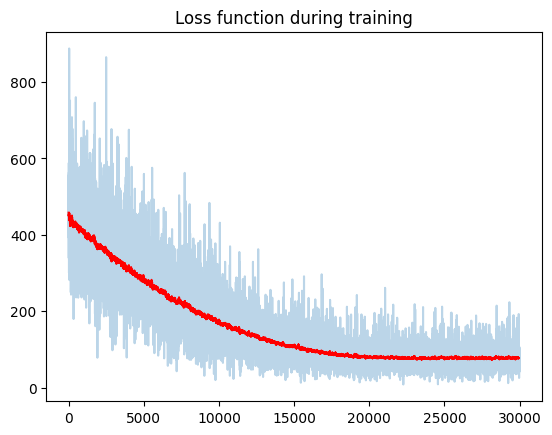

In [22]:
# Display the list containing the values of the loss function
# and a smoothed version (red) to observe the trend
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Loss function during training")

Mean MSE in training with 2 neurons: 77.30453
Mean MSE in test with 2 neurons: 54.827194


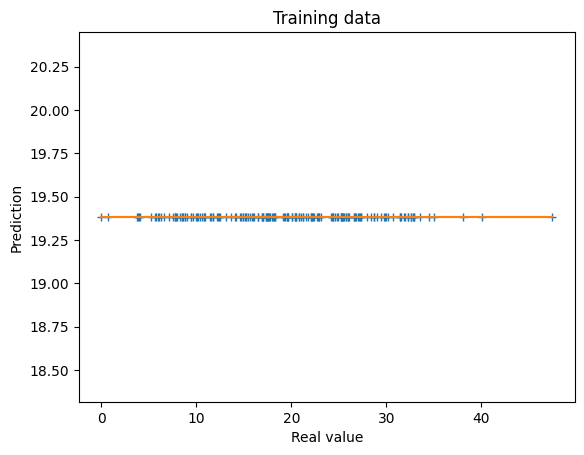

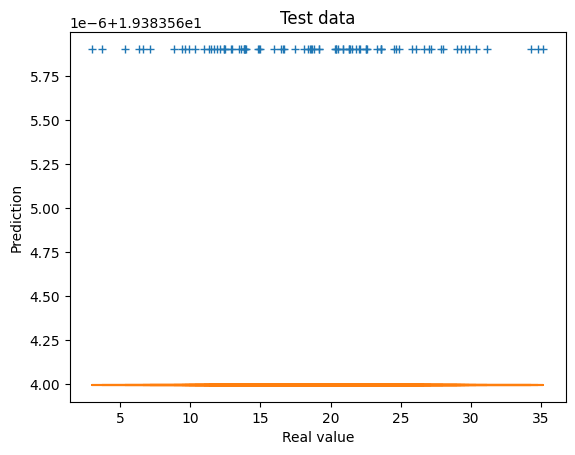

In [23]:
# We draw the ground truth vs the predictions on the training data.
py = net(torch.FloatTensor(X_train))
y_pred_train = py.cpu().detach().numpy()
plotScatter(y_train, y_pred_train, "Training data")

# We draw the ground truth vs the predictions on the test data.
py = net(torch.FloatTensor(X_test))
y_pred_test = py.cpu().detach().numpy()
plotScatter(y_test, y_pred_test, "Test data")

MSE2_train = ((y_train - y_pred_train)**2).mean()
MSE2_test = ((y_test - y_pred_test)**2).mean()

print ("Mean MSE in training with 2 neurons: " + str(MSE2_train))
print ("Mean MSE in test with 2 neurons: " + str(MSE2_test))

we will analyze the results at the end!

## Multilayer Perceptron with 10 neurons per layer trained for 5000 epochs

In [24]:
# We instantiate the object of the previously defined Net class (perceptron)
net = Net( input_features= data.shape[1] , size_hidden = 10 , n_output = 1 )
net

Net(
  (hidden1): Linear(in_features=14, out_features=10, bias=True)
  (hidden2): Linear(in_features=10, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# We construct the optimizer
optimizer = torch.optim.Adam( net.parameters() , lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [26]:
# Number of epochs
num_epochs = 5000

# List where we will keep track of the loss function value at each
# training stage
loss_list = []

# Training loop
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        # Set gradients of the parameters to optimize to zero
        optimizer.zero_grad()

        # Perform the forward pass through the network
        outputs = net(x)
        loss = criterion(outputs, y)

        # Perform the backward pass through the network
        loss.backward()

        # Update the weights of the network with the optimizer
        optimizer.step()

        # I save the current value of the loss function to later plot it
        loss_list.append(loss.data.item())

        # I accumulate the loss of the minibatch
        total_loss += loss.item() * y.size(0)

    # I normalize the total loss
    total_loss/= len(loader.dataset)

    # I display the value of the loss function every 100 iterations
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

Epoch 100, loss = 421.754
Epoch 200, loss = 60.6138
Epoch 300, loss = 51.1838
Epoch 400, loss = 38.5562
Epoch 500, loss = 27.7509
Epoch 600, loss = 25.8885
Epoch 700, loss = 25.2594
Epoch 800, loss = 22.781
Epoch 900, loss = 21.7382
Epoch 1000, loss = 21.0761
Epoch 1100, loss = 20.4801
Epoch 1200, loss = 19.8867
Epoch 1300, loss = 21.6096
Epoch 1400, loss = 19.3652
Epoch 1500, loss = 20.3997
Epoch 1600, loss = 19.3588
Epoch 1700, loss = 19.418
Epoch 1800, loss = 18.9006
Epoch 1900, loss = 19.2176
Epoch 2000, loss = 20.1033
Epoch 2100, loss = 19.4951
Epoch 2200, loss = 19.0525
Epoch 2300, loss = 19.0592
Epoch 2400, loss = 19.3688
Epoch 2500, loss = 18.9455
Epoch 2600, loss = 18.8612
Epoch 2700, loss = 19.2961
Epoch 2800, loss = 19.4681
Epoch 2900, loss = 18.7235
Epoch 3000, loss = 18.285
Epoch 3100, loss = 18.7334
Epoch 3200, loss = 18.8609
Epoch 3300, loss = 18.4797
Epoch 3400, loss = 18.5395
Epoch 3500, loss = 18.4334
Epoch 3600, loss = 18.827
Epoch 3700, loss = 18.8313
Epoch 3800, lo

Text(0.5, 1.0, 'Loss function during training')

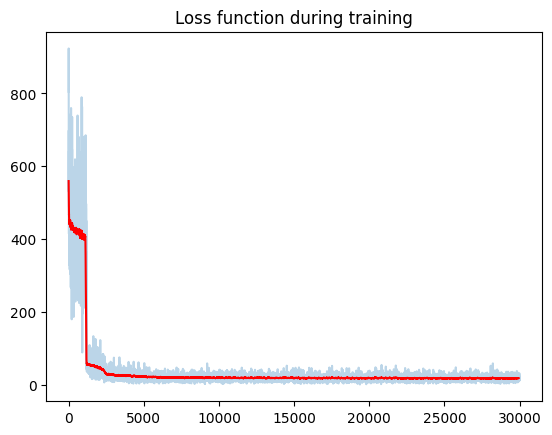

In [27]:
# Display the list containing the values of the loss function
# and a smoothed version (red) to observe the trend
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Loss function during training")

Mean MSE in training with 10 neurons: 17.886864
Mean MSE in test with 10 neurons: 18.754414


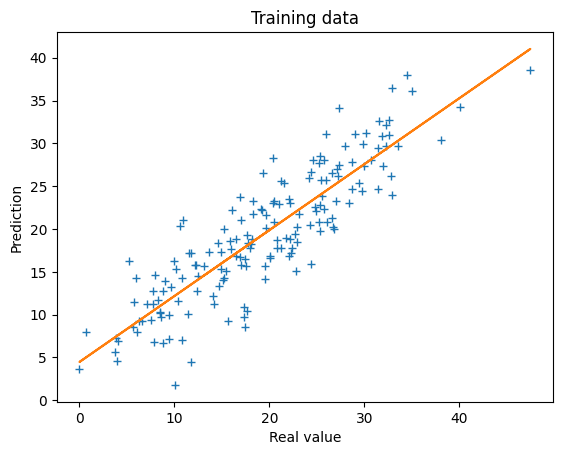

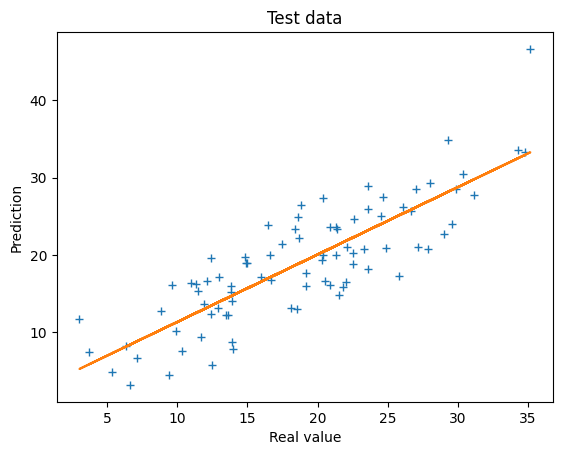

In [28]:
# We draw the ground truth vs the predictions on the training data.
py = net(torch.FloatTensor(X_train))
y_pred_train = py.cpu().detach().numpy()
plotScatter(y_train, y_pred_train, "Training data")

# We draw the ground truth vs the predictions on the test data.
py = net(torch.FloatTensor(X_test))
y_pred_test = py.cpu().detach().numpy()
plotScatter(y_test, y_pred_test, "Test data")

MSE10_train = ((y_train - y_pred_train)**2).mean()
MSE10_test = ((y_test - y_pred_test)**2).mean()
print ("Mean MSE in training with 10 neurons: " + str(MSE10_train))
print ("Mean MSE in test with 10 neurons: " + str(MSE10_test))

## Analysis of the relationship between results and the number of neurons that the perceptron has.

In [29]:
print("Training MSE with 2 Neurons:", MSE2_train)
print("Test MSE with 2 Neurons: ", MSE2_test, "\n")
print("Training MSE with 10 Neurons:", MSE10_train)
print("Test MSE with 10 Neurons: ", MSE10_test, "\n")
print("Training MSE with 200 Neurons:", MSE200_train)
print("Test MSE with 200 Neurons: ", MSE200_test)

Training MSE with 2 Neurons: 77.30453
Test MSE with 2 Neurons:  54.827194 

Training MSE with 10 Neurons: 17.886864
Test MSE with 10 Neurons:  18.754414 

Training MSE with 200 Neurons: 0.32137474
Test MSE with 200 Neurons:  34.73385


*   **With 2 neurons in the hidden layers:** we obtain an MSE of approximately 77.30 on the training set and an MSE of around 54.82 on the test set. The model is experiencing a high level of error in both the training and test sets, reflecting its lack of fitting capacity to capture the complexity of the data. This is why the phenomenon of two parallel lines between the real and predicted values can be seen in the scatter plots for this case.

*   **With 10 neurons in the hidden layers:** a significant improvement in model performance is observed. The MSE on the training set decreases considerably to approximately 17.88, indicating a better fitting capacity of the model to the training data. Additionally, the MSE on the test set also decreases to around 18.75, reflecting an improvement in the model's generalization or inference capacity for unseen data.

*   **With 200 neurons in the hidden layers:** even better performance is achieved on the training set, with a very low MSE of approximately 0.03. However, in the test set, the MSE increases to around 34.73 compared to the 10-neuron model. This shows that the model with 200 neurons is experiencing overfitting on the training set, resulting in inferior generalization capacity on the test set.

# BONUS: Model optimization through normalization, dropout, and modification of the model architecture to improve MSE on the test set.

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class Net(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output, dropout_rate=0.2): # We add Dropout to the hidden layers with an activation probability of 80%
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return x

Epoch 100, loss = 7.01275
Epoch 200, loss = 4.81647
Epoch 300, loss = 4.30521
Epoch 400, loss = 4.37565
Epoch 500, loss = 3.27426
Epoch 600, loss = 3.07511
Epoch 700, loss = 3.48086
Epoch 800, loss = 2.9461
Epoch 900, loss = 3.62868
Epoch 1000, loss = 2.55456
Epoch 1100, loss = 3.49898
Epoch 1200, loss = 2.78446
Epoch 1300, loss = 2.63239
Epoch 1400, loss = 2.74904
Epoch 1500, loss = 2.15311
Epoch 1600, loss = 2.15678
Epoch 1700, loss = 2.54065
Epoch 1800, loss = 2.36486
Epoch 1900, loss = 2.36298
Epoch 2000, loss = 1.98732
Epoch 2100, loss = 2.18047
Epoch 2200, loss = 2.19392
Epoch 2300, loss = 1.97082
Epoch 2400, loss = 2.09593
Epoch 2500, loss = 1.73515
Epoch 2600, loss = 2.07594
Epoch 2700, loss = 2.06923
Epoch 2800, loss = 1.96032
Epoch 2900, loss = 2.3236
Epoch 3000, loss = 2.32617
Epoch 3100, loss = 1.85969
Epoch 3200, loss = 1.88064
Epoch 3300, loss = 1.82697
Epoch 3400, loss = 1.66221
Epoch 3500, loss = 1.51264
Epoch 3600, loss = 1.69812
Epoch 3700, loss = 2.03795
Epoch 3800, 

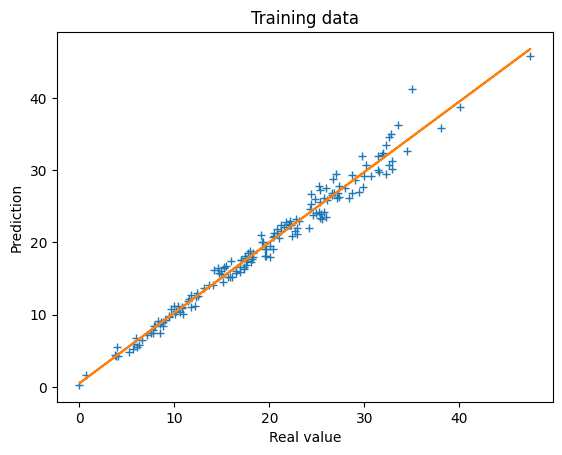

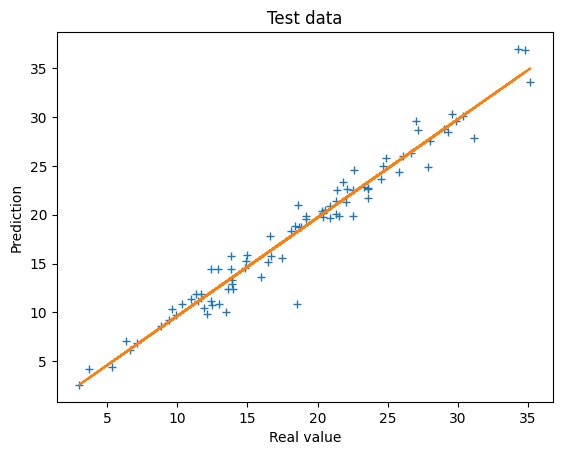

In [31]:
# Import the necessary libraries
from sklearn.preprocessing import StandardScaler

# Normalize the training data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Normalize the test data
X_test_normalized = scaler.transform(X_test)

# Instantiate the Net class object with 100 neurons for the hidden layers
net = Net(input_features=X_train_normalized.shape[1], size_hidden=100, n_output=1)

# Construct the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Create datasets and loaders with the normalized data
train_dataset = TensorDataset(torch.from_numpy(X_train_normalized), torch.from_numpy(y_train))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(X_test_normalized), torch.from_numpy(y_test))
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Number of epochs
num_epochs = 5000

# List to store the value of the loss function at each training stage
loss_list = []

# Training loop
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in train_loader:
        # Set gradients of the parameters to optimize to zero
        optimizer.zero_grad()

        # Perform the forward pass through the network
        outputs = net(x)
        loss = criterion(outputs, y)

        # Perform the backward pass through the network
        loss.backward()

        # Update the weights of the network with the optimizer
        optimizer.step()

        # Save the current value of the loss function to later plot it
        loss_list.append(loss.data.item())

        # Accumulate the loss of the minibatch
        total_loss += loss.item() * y.size(0)

    # Normalize the total loss
    total_loss /= len(train_loader.dataset)

    # Display the value of the loss function every 100 iterations
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

# Draw the ground truth vs predictions on the training data
py = net(torch.FloatTensor(X_train_normalized))
y_pred_train = py.cpu().detach().numpy()
plotScatter(y_train, y_pred_train, "Training data")

# Draw the ground truth vs predictions on the test data
py = net(torch.FloatTensor(X_test_normalized))
y_pred_test = py.cpu().detach().numpy()
plotScatter(y_test, y_pred_test, "Test data")

MSE100_train = ((y_train - y_pred_train)**2).mean()
MSE100_test = ((y_test - y_pred_test)**2).mean()
print("Training MSE with 100 Neurons:", MSE100_train)
print("Test MSE with 100 Neurons:     ", MSE100_test)



Text(0.5, 1.0, 'Loss function during training')

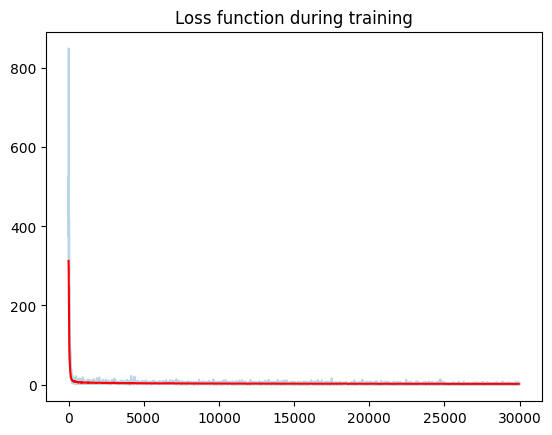

In [32]:
# Display the list containing the values of the loss function
# and a smoothed version (red) to observe the trend
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha=0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Loss function during training")



RESULTS:

Training MSE with 100 Neurons: 1.56

Test MSE with 100 Neurons: 2.41

It can be observed that by applying normalization, dropout, and modifying the perceptron architecture to 100 neurons in each internal layer, we improved the test MSE to 2.41.